# Simulating different noise "LFPs" and analyzing their spectral distribution

In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import sys

font = {'family' : 'arial',
        'weight' : 'regular',
        'size'   : 15}
import matplotlib
matplotlib.rc('font', **font)

sys.path.append('/Users/rdgao/Documents/code/research/neurodsp/')
import neurodsp as ndsp
sys.path.append('/Users/rdgao/Documents/code/research/spectralCV/')
from scv_funcs import lfpca, utils

# Double exponential synaptic noise LFP
Here, we simulate 1/f background activity as a convolution between Poisson noise and exponential rise and decay synaptic kernel (post-synaptic current).

In [33]:
# simulating
np.random.seed(42)
numtrials=50
T = 120
fs = 1000
tauR=0.002
tauD=0.02
syn_noise = np.zeros((numtrials, T*fs))
for tr in range(numtrials): 
    syn_noise[tr,:] = ndsp.sim_synaptic_noise(T,fs,tauR=tauR,tauD=tauD)
    
# analysis
params = {'nperseg':1000, 'noverlap':0, 'spg_outlierpct':0, 'max_freq':200}
sn_lfpca = lfpca.LFPCA(params)
sn_lfpca.populate_ts_data(syn_noise,fs)
sn_lfpca.compute_all_spectral()
sn_lfpca.compute_KS_expfit()

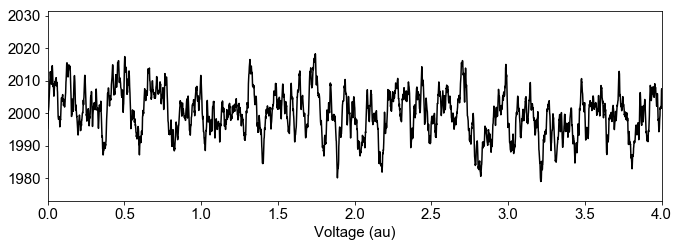

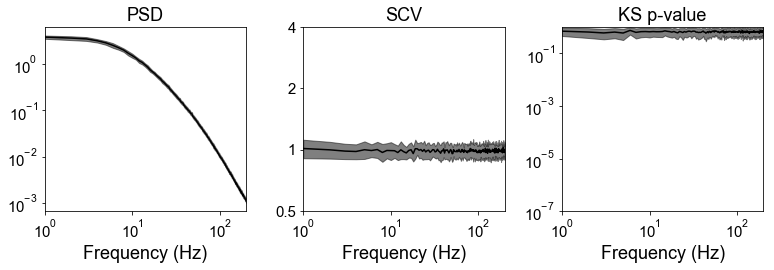

In [39]:
plt.figure(figsize=(11,3.5))
plt.plot(np.arange(0,T,1/fs),syn_noise[0,:], 'k')
plt.xlabel('Time (s)')
plt.xlabel('Voltage (au)')
plt.xlim([0,4])
plt.figure(figsize=(11,4))
sn_lfpca.plot_spectral(plot_mean=True)

### Observation: colored noise follows noise distribution at all frequencies
As expected, the PSD follows a plateaued 1/f function (Lorentzian), and spectral coefficient of variation (SCV) at all frequencies is equal to unity. Power distribution at all frequencies are not significantly different from exponential distribution parametrized by the mean power, under KS test.

# Effect of window length and overlap length on noise power

In [4]:
# analysis
params = {'nperseg':250, 'noverlap':0, 'spg_outlierpct':0, 'max_freq':200}
sn_lfpca = lfpca.LFPCA(params)
sn_lfpca.populate_ts_data(syn_noise,fs)
sn_lfpca.compute_all_spectral()
sn_lfpca.compute_KS_expfit()

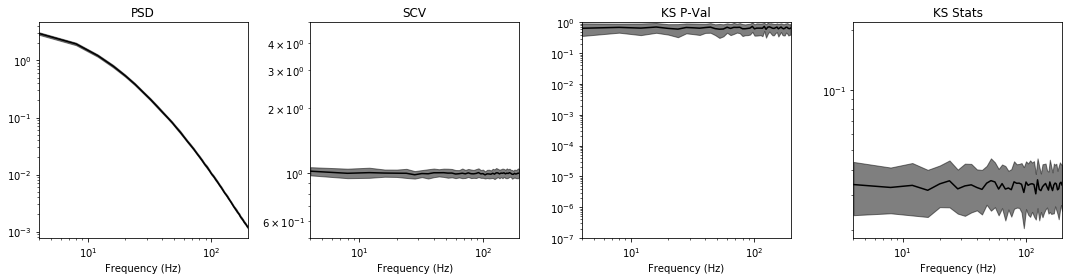

In [5]:
plt.figure(figsize=(15,4))
sn_lfpca.plot_spectral(plot_mean=True)

### Observation: STFT window length does not affect noise power
Exponential distribution of power does not depend on window-length: with a smaller window length (quarter second), power in adjacent frequency bins are collapsed into every 4th bin and each bin remains exponentially distributed. This means that narrowband filtering and taking the Hilbert power in a "noise" region should maintain the noise-like properties of that band.

In [81]:
# analysis
noverlap = [0, 100, 250, 500, 750]
spg_len = int(syn_noise.shape[1]/fs)
lfpca_all = []
lfpca_samelen = []
num_tr = numtrials
for no in noverlap:
    params = {'nperseg':1000, 'noverlap':no, 'spg_outlierpct':0, 'max_freq':200}
    sn_lfpca = lfpca.LFPCA(params)
    sn_lfpca.populate_ts_data(syn_noise[:num_tr,:],fs)
    sn_lfpca.compute_all_spectral()
    sn_lfpca.compute_KS_expfit()
    lfpca_all.append(sn_lfpca)
    
    # compute with the same number of spg slices
    sn_lfpca = lfpca.LFPCA(params)
    sn_lfpca.populate_ts_data(syn_noise[:num_tr,:],fs) #sub-select only 10 trials
    sn_lfpca.compute_spg()
    sn_lfpca.spg = sn_lfpca.spg[:,:,:spg_len]
    sn_lfpca.compute_psd()
    sn_lfpca.compute_scv()
    sn_lfpca.compute_KS_expfit()
    lfpca_samelen.append(sn_lfpca)

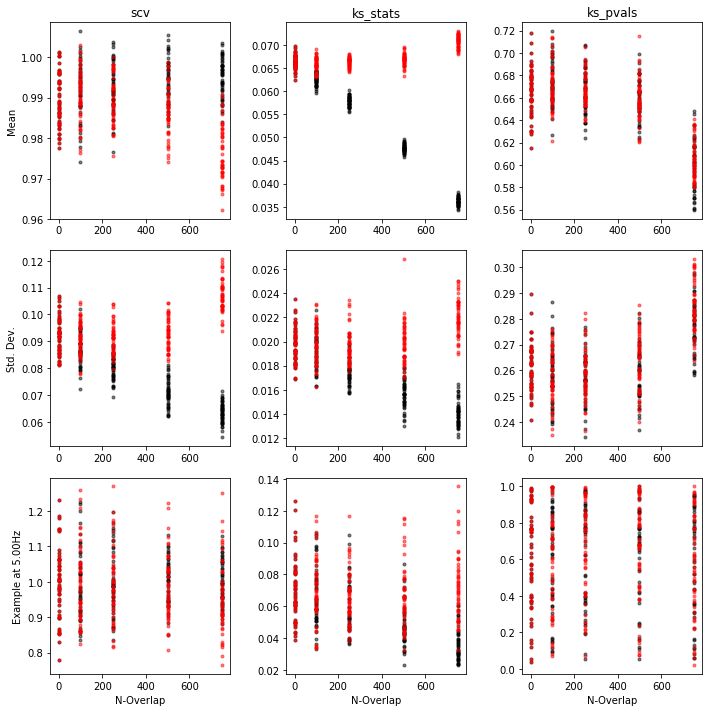

In [86]:
# plot averages and an example frequency
plot_freq = 5
attrs = ['scv', 'ks_stats', 'ks_pvals']
plt.figure(figsize=(10,10))
for i in range(len(attrs)):
    plt.subplot(3,len(attrs),i+1)
    plt.plot(noverlap, np.array([lf.__dict__[attrs[i]].mean(axis=1) for lf in lfpca_all]), 'k.', alpha=0.5)
    plt.plot(noverlap, np.array([lf.__dict__[attrs[i]].mean(axis=1) for lf in lfpca_samelen]), 'r.', alpha=0.5)
    plt.title(attrs[i])
    if i==0: plt.ylabel('Mean')
    plt.subplot(3,len(attrs),i+1+len(attrs))
    if i==0: plt.ylabel('Std. Dev.')
    plt.plot(noverlap, np.array([lf.__dict__[attrs[i]].std(axis=1) for lf in lfpca_all]), 'k.', alpha=0.5)
    plt.plot(noverlap, np.array([lf.__dict__[attrs[i]].std(axis=1) for lf in lfpca_samelen]), 'r.', alpha=0.5)
    plt.subplot(3,len(attrs),i+1+len(attrs)*2)
    plt.plot(noverlap, np.array([lf.__dict__[attrs[i]][:,plot_freq] for lf in lfpca_all]), 'k.', alpha=0.5)
    plt.plot(noverlap, np.array([lf.__dict__[attrs[i]][:,plot_freq] for lf in lfpca_samelen]), 'r.', alpha=0.5)
    if i==0: plt.ylabel('Example at %.2fHz'%lfpca_all[0].f_axis[plot_freq])
    plt.xlabel('N-Overlap')
plt.tight_layout()

### Observation: reasonable overlap length (half-window) makes little impact on tests but improves estimate
- Overlap length doesn't effect SCV amplitude, but more overlap reduces SCV variance, at least across frequencies, which is reasonable as there are more samples to include. 
- However, increasing overlap size drastically affects KS-test statistic and p-value. Test statistic decreases as a function of overlap length when the full spectrogram is used (black), and so does p-value. This could be due to two reasons: 1. there are just more samples to establish significance, and/or 2. the overlap in STFT windows actually introduce autocorrelation and skew the distribution.
- When the same number of spectrogram slices is used in each overlap length instead(red), KS test statistic remains roughly constant, and p-value slightly decreases as a function of overlap length. Importantly, SCV also seem to decrease (slightly).
- This suggests that KS-test statistic is only a function of sample size, and not the overlap itself. P-value, however, seems to be a function of overlap length, and not sample size? 
- Practically, it appears that an overlap length of half the window does no significantly change the results.

# Fine-grained power distribution computed via filter-Hilbert transform
- In theory, each sample of signal power should be drawn independently from the underlying distribution, especially where KS test (and all other statistical tests) assumes iid. 
- However, bandpass filtering introduces autocorrelation in the power time series by virtue of the convolution operation. To mitigate this effect and still produce independent draws, we can take every Nth sample in the power series, where N is the effective length of the filter estimated as the length where filter autocorrelation drops below a threshold. In other words, power samples N-steps away effectively have no raw data in common during filtering.

In [5]:
N_cycles=7
noise_band = (30,50)
filt_thr = 0.05
_, _, _, ker_len = lfpca.compute_BP_HT(syn_noise[0,:],fs,noise_band,N_cycles,filt_thr)
skip_lens = [1, int(ker_len/4), int(ker_len/2), ker_len]
test_stats = np.zeros((numtrials, 4, len(skip_lens)))
for tr, data in enumerate(syn_noise):
    noise_power, _, val_inds, ker_len = lfpca.compute_BP_HT(data-data.mean(),fs,noise_band,N_cycles,filt_thr)
    for ind, sl in enumerate(skip_lens):
        test_stats[tr,[0,2,3],ind] = lfpca.fit_test_exp(noise_power[val_inds][::sl])
        test_stats[tr,1,ind] = noise_power[val_inds][::sl].std()/noise_power[val_inds][::sl].mean()

/Users/rdgao/Documents/code/research/neurodsp/neurodsp/filt.py:78: UserWarning: "f_lo" or "f_hi" inputs are being deprecated. Use "fc" to specify cutoff frequencies.
  warnings.warn('"f_lo" or "f_hi" inputs are being deprecated. Use "fc" to specify cutoff frequencies.')
/Users/rdgao/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/rdgao/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


/Users/rdgao/Documents/code/research/neurodsp/neurodsp/filt.py:78: UserWarning: "f_lo" or "f_hi" inputs are being deprecated. Use "fc" to specify cutoff frequencies.
  warnings.warn('"f_lo" or "f_hi" inputs are being deprecated. Use "fc" to specify cutoff frequencies.')
/Users/rdgao/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/rdgao/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


All samples: SCV: 0.992, p-val: 0.008
Skip samples: SCV: 0.986, p-val: 0.766


/Users/rdgao/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


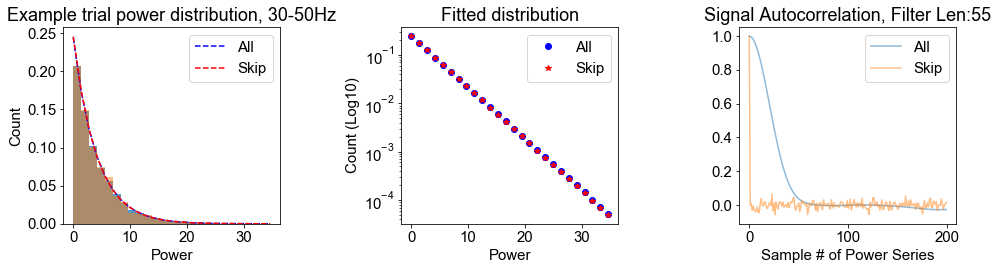

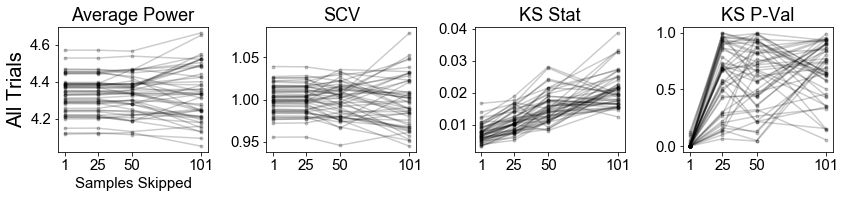

In [10]:
filt_thr = 0.05
noise_band = (30,50)
plot_tr = 10
noise_power, noise_phase, val_inds, ker_len = lfpca.compute_BP_HT(syn_noise[plot_tr,:]-syn_noise[plot_tr,:].mean(),fs,noise_band,5,filt_thr)
noise_power = noise_power[val_inds]
noise_power_decorr = noise_power[::ker_len]

plt.figure(figsize=(14,4))
plt.subplot(1,3,1)
counts,bins,_ = plt.hist(noise_power, bins=25, normed=True, alpha=0.75);
counts,bins,_ = plt.hist(noise_power_decorr, bins=bins, normed=True, alpha=0.5);
plt.plot(bins, sp.stats.expon(scale=sp.stats.expon.fit(noise_power,floc=0)[1]).pdf(bins), 'b--', label='All')
plt.plot(bins, sp.stats.expon(scale=sp.stats.expon.fit(noise_power_decorr,floc=0)[1]).pdf(bins), 'r--',label='Skip')
plt.xlabel('Power')
plt.ylabel('Count')
plt.title('Example trial power distribution, %i-%iHz'%noise_band)
plt.legend()

plt.subplot(1,3,2)
plt.semilogy(bins, sp.stats.expon(scale=sp.stats.expon.fit(noise_power,floc=0)[1]).pdf(bins), 'ob')
plt.semilogy(bins, sp.stats.expon(scale=sp.stats.expon.fit(noise_power_decorr,floc=0)[1]).pdf(bins),'r*')
plt.xlabel('Power')
plt.ylabel('Count (Log10)')
plt.legend(['All', 'Skip'])
plt.title('Fitted distribution')

plt.subplot(1,3,3)
plt.plot(utils.autocorr(noise_power,200)[1], alpha=0.5)
plt.plot(utils.autocorr(noise_power_decorr,200)[1],alpha=0.5)
plt.xlabel('Sample # of Power Series')
plt.legend(['All', 'Skip'])
plt.title('Signal Autocorrelation, Filter Len:%i'%ker_len)
plt.tight_layout()

## ----
lam, ksstat, kspval = lfpca.fit_test_exp(noise_power)
print('All samples: SCV: %.3f, p-val: %.3f'%(noise_power.std()/noise_power.mean(),kspval))
lam, ksstat, kspval = lfpca.fit_test_exp(noise_power_decorr)
print('Skip samples: SCV: %.3f, p-val: %.3f'%(noise_power_decorr.std()/noise_power_decorr.mean(),kspval));

plt.figure(figsize=(12,3))
labels=['Average Power', 'SCV', 'KS Stat', 'KS P-Val']
for i in range(4):
    plt.subplot(1,4,i+1)
    plt.plot(skip_lens,test_stats[:,i,:].T, '.-k', alpha=0.2);
    plt.xticks(skip_lens)
    plt.title(labels[i])
plt.subplot(1,4,1)
plt.ylabel('All Trials', fontsize=20)
plt.xlabel('Samples Skipped')
plt.tight_layout()

### Observation: filter introduces power autocorrelation but does not effect power or SCV estimate of noise
- Comparing power and SCV produced by the every-sample (all) and skip-sample (skip) sampling, though, shows very little difference. KS testing, however, reports significant difference from observed to the exponential null hypothesis, presumably due to the increased number of samples. It's unclear whether the observed distributions are at all different as the empirical and fitted distributions are almost identical.
- Similar to fitting power distributions obtained from the spectrogram, practically, having a half-window or even 3/4 window overlap is acceptable.

# Simulating stationary and bursty oscillation in noise
Now add a stationary oscillation (theta) and a bursty oscillation (beta) to the underlying 1/f background. We should expect the theta band to have low SCV, while beta band to have high SCV.

In [25]:
# simulating
np.random.seed(42)
numtrials=50
T = 120
fs = 1000
tauR=0.002
tauD=0.02
theta_freq=4
theta_amp=15
beta_freq=23
beta_amp=6
syn_osc = np.zeros((numtrials, T*fs))
for tr in range(numtrials): 
    noise = ndsp.sim_synaptic_noise(T,fs,tauR=tauR,tauD=tauD)
    # stationary theta: high entering probability and low leaving probability
    theta = ndsp.sim_bursty_oscillator(theta_freq,T,fs, rdsym=0.5, prob_enter_burst=1, prob_leave_burst=0.1)
    # bursty beta: low entering probability and low leaving probability
    beta = ndsp.sim_bursty_oscillator(beta_freq,T,fs, rdsym=0.5, prob_enter_burst=0.1, prob_leave_burst=0.1)
    syn_osc[tr,:] = noise+theta_amp*theta+beta_amp*beta

# analysis
params = {'nperseg':1000, 'noverlap':0, 'spg_outlierpct':0, 'max_freq':200}
osc_lfpca = lfpca.LFPCA(params)
osc_lfpca.populate_ts_data(syn_osc,fs)
osc_lfpca.compute_all_spectral()
osc_lfpca.compute_KS_expfit()

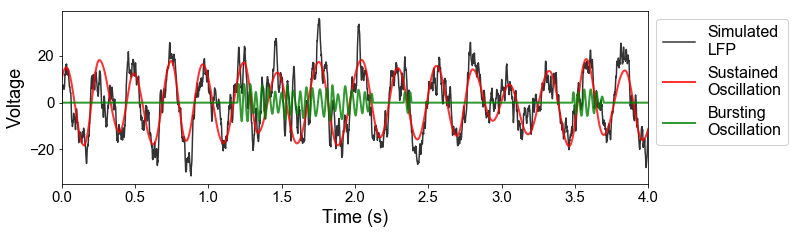

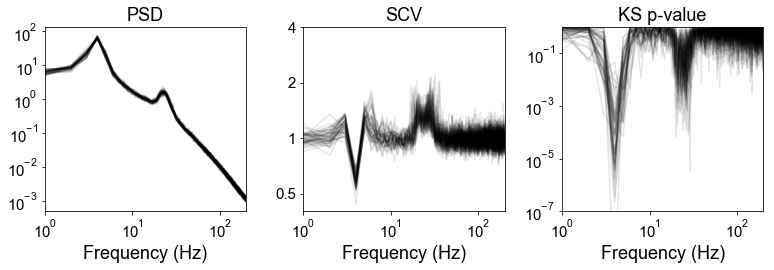

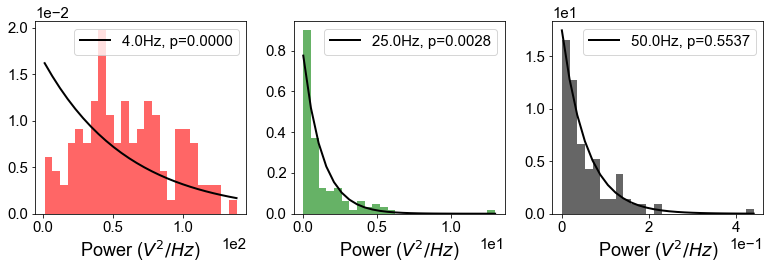

In [40]:
plot_tr = -1
plt.figure(figsize=(9.5,3.5))
plt.plot(np.arange(0,4,1/fs), syn_osc[plot_tr,4000:8000]-syn_osc[plot_tr,4000:8000].mean(), 'k', alpha=0.8, label='Simulated\nLFP')
plt.plot(np.arange(0,4,1/fs), theta_amp*theta[4000:8000], lw=2, alpha=0.8, color='r', label='Sustained\nOscillation')
plt.plot(np.arange(0,4,1/fs), beta_amp*beta[4000:8000],lw=2, alpha=0.8, color='g', label='Bursting\nOscillation')
plt.xlim([0,4])
plt.xlabel('Time (s)', fontsize=18)
plt.ylabel('Voltage', fontsize=18)
plt.legend(loc='upper right',fontsize=18)
plt.legend(loc='upper left', fontsize=16, framealpha=0.9,bbox_to_anchor=(1, 1))
plt.tight_layout()

plt.figure(figsize=(11,4))
osc_lfpca.plot_spectral(plot_mean=False)

plt.figure(figsize=(11,4))
plot_freqs = [4,25,50]
plot_colors = ['r','g','k']
for i in range(3):
    plt.subplot(1,3,i+1)
    osc_lfpca.plot_expfit(plot_tr,plot_freqs[i],25)
    ax = plt.gca()
    [[p.set_facecolor(plot_colors[i]),p.set_alpha(0.6)] for p in ax.patches]
    plt.ticklabel_format(style='sci', axis='both', scilimits=(0,0))

plt.tight_layout()

### Observation: deviations from noise are picked up by SCV and KS test
As expected, we see two peaks in the PSD, one at theta and one at beta frequency. However, the theta frequencies have SCV<1 due to a steady concentration of power, while the beta frequencies have higher variability, with a somewhat bimodal distribution of power (noise or oscillation). All other frequencies remain noise-like. Both frequency bands test significantly different from the exponential null more often.

# Effect of overlap length on oscillations

In [99]:
# analysis
noverlap = [0, 100, 250, 500, 750]
spg_len = int(syn_osc.shape[1]/fs)
lfpca_all = []
lfpca_samelen = []
num_tr = numtrials
for no in noverlap:
    params = {'nperseg':1000, 'noverlap':no, 'spg_outlierpct':0, 'max_freq':200}
    sn_lfpca = lfpca.LFPCA(params)
    sn_lfpca.populate_ts_data(syn_osc[:num_tr,:],fs)
    sn_lfpca.compute_all_spectral()
    sn_lfpca.compute_KS_expfit()
    lfpca_all.append(sn_lfpca)
    
    # compute with the same number of spg slices
    sn_lfpca = lfpca.LFPCA(params)
    sn_lfpca.populate_ts_data(syn_osc[:num_tr,:],fs) #sub-select only 10 trials
    sn_lfpca.compute_spg()
    sn_lfpca.spg = sn_lfpca.spg[:,:,:spg_len]
    sn_lfpca.compute_psd()
    sn_lfpca.compute_scv()
    sn_lfpca.compute_KS_expfit()
    lfpca_samelen.append(sn_lfpca)

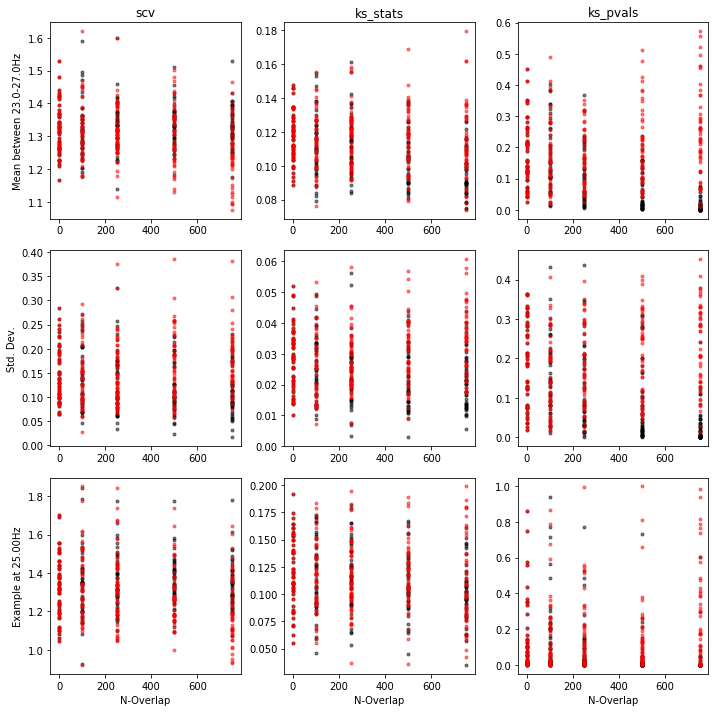

In [109]:
# plot averages and an example frequency
plot_freq = 25
avg_freqs = range(23,28)
attrs = ['scv', 'ks_stats', 'ks_pvals']
plt.figure(figsize=(10,10))
for i in range(len(attrs)):
    plt.subplot(3,len(attrs),i+1)
    plt.plot(noverlap, np.array([lf.__dict__[attrs[i]][:,avg_freqs].mean(axis=1) for lf in lfpca_all]), 'k.', alpha=0.5)
    plt.plot(noverlap, np.array([lf.__dict__[attrs[i]][:,avg_freqs].mean(axis=1) for lf in lfpca_samelen]), 'r.', alpha=0.5)
    plt.title(attrs[i])
    if i==0: plt.ylabel('Mean between %.1f-%.1fHz'%(avg_freqs[0], avg_freqs[-1]))
    plt.subplot(3,len(attrs),i+1+len(attrs))
    if i==0: plt.ylabel('Std. Dev.')
    plt.plot(noverlap, np.array([lf.__dict__[attrs[i]][:,avg_freqs].std(axis=1) for lf in lfpca_all]), 'k.', alpha=0.5)
    plt.plot(noverlap, np.array([lf.__dict__[attrs[i]][:,avg_freqs].std(axis=1) for lf in lfpca_samelen]), 'r.', alpha=0.5)
    plt.subplot(3,len(attrs),i+1+len(attrs)*2)
    plt.plot(noverlap, np.array([lf.__dict__[attrs[i]][:,plot_freq] for lf in lfpca_all]), 'k.', alpha=0.5)
    plt.plot(noverlap, np.array([lf.__dict__[attrs[i]][:,plot_freq] for lf in lfpca_samelen]), 'r.', alpha=0.5)
    if i==0: plt.ylabel('Example at %.2fHz'%lfpca_all[0].f_axis[plot_freq])
    plt.xlabel('N-Overlap')
plt.tight_layout()

### Observation: overlap length does not affect oscillation SCV or KS test
For both stationary and bursting oscillations, increasing overlap length does not seem to impact SCV or KS test results.

# Simulating "asynchronous" oscillator
Now we simulate an oscillation that rises above the background 1/f, but retains noise-like statistics, i.e. narrow-band filtered noise.

In [118]:
# simulating
np.random.seed(42)
numtrials=50
T = 120
fs = 1000
tauR=0.002
tauD=0.02
beta_white_amp=30.
beta_color_amp=2
syn_white_osc = np.zeros((numtrials, T*fs))
syn_color_osc = np.zeros((numtrials, T*fs))
for tr in range(numtrials): 
    noise = ndsp.sim_synaptic_noise(T,fs,tauR=tauR,tauD=tauD)
    # narrowband filtered WHITE noise
    async_beta_white = ndsp.filter(np.random.randn((T+1)*fs),fs,'bandpass',f_lo=23,f_hi=27,N_cycles=9)
    syn_white_osc[tr,:] = noise+beta_white_amp*async_beta_white[~np.isnan(async_beta_white)][:len(noise)]

    # narrowband filtered SYNAPTIC noise
    async_beta_color = ndsp.filter(ndsp.sim_synaptic_noise(T+1.,fs,tauR=tauR,tauD=tauD),fs,'bandpass',f_lo=23,f_hi=27,N_cycles=9)
    syn_color_osc[tr,:] = noise+beta_color_amp*async_beta_color[~np.isnan(async_beta_color)][:len(noise)]

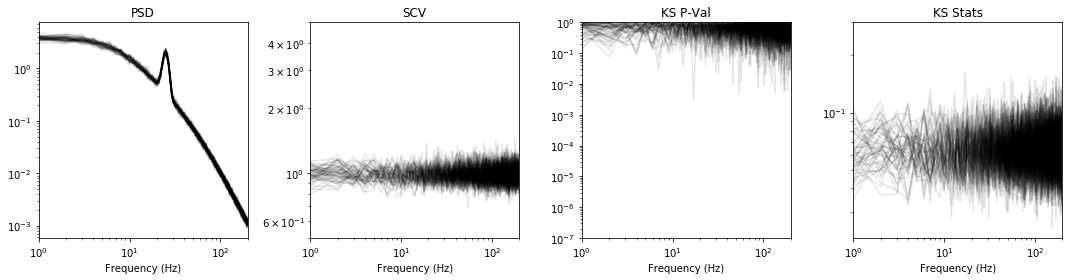

In [119]:
# analysis
params = {'nperseg':1000, 'noverlap':0, 'spg_outlierpct':0, 'max_freq':200}
osc_lfpca = lfpca.LFPCA(params)
osc_lfpca.populate_ts_data(syn_white_osc,fs)
osc_lfpca.compute_all_spectral()
osc_lfpca.compute_KS_expfit()
plt.figure(figsize=(15,4))
osc_lfpca.plot_spectral(plot_mean=False)

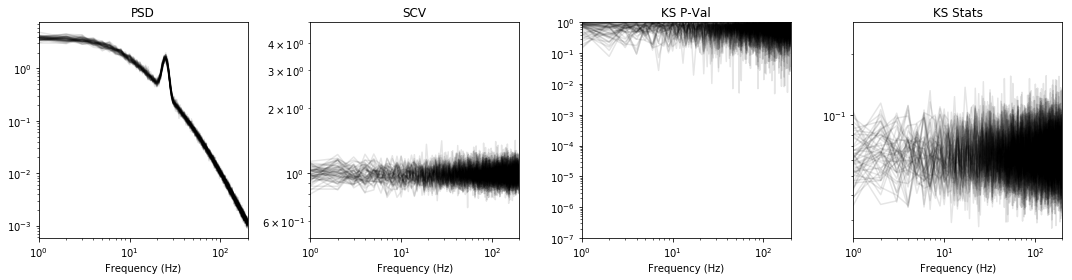

In [120]:
# analysis
params = {'nperseg':1000, 'noverlap':0, 'spg_outlierpct':0, 'max_freq':200}
osc_lfpca = lfpca.LFPCA(params)
osc_lfpca.populate_ts_data(syn_color_osc,fs)
osc_lfpca.compute_all_spectral()
osc_lfpca.compute_KS_expfit()
plt.figure(figsize=(15,4))
osc_lfpca.plot_spectral(plot_mean=False)

### Observation: noise (or asynchronous) oscillator does not exhibit deviation from noise statistics
Since the amplitude of the noise-filtered oscillation retains its exponential distribution, it cannot be detected based on SCV or KS test.

# Synaptic + local spiking (broadband) noise (multiplicative + additive)
Here, we simulate 1/f background activity as a convolution between Poisson noise and exponential rise and decay synaptic kernel (post-synaptic current). On top of that, we add the Poisson noise to represent local circuit spiking.

201


/Users/rdgao/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


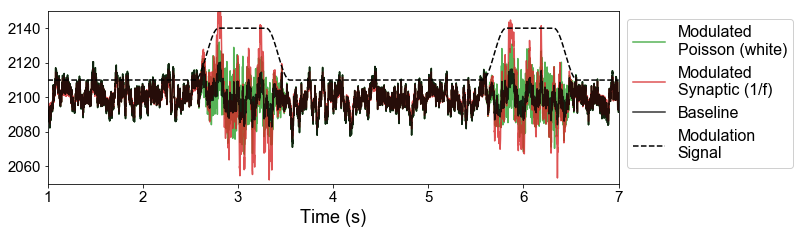

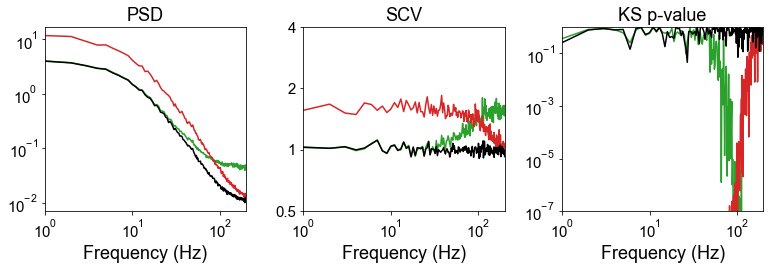

In [85]:
fs = 1000
T = 600
t = np.arange(0,T,1/fs)
wn_factor = 0.05
N_neurons=1000
FR=2
tauR=0.002
tauD=0.02

# get modulation signal
np.random.seed(10)
trial_interval = 3*fs
trial_length = 1*fs
mod_amp = 3
event_times = np.cumsum(np.random.poisson(trial_interval, int((T+5)*fs/trial_interval)))
print(len(event_times))
mod = np.zeros(event_times[-1]+1)
mod[event_times]=1
mod = mod_amp*sp.convolve(sp.signal.windows.tukey(int(trial_length)), mod,mode='same')+1
mod = mod[:len(t)]
#mod = (np.cos(0.01*np.pi*2.*t)+2)*1 # amplitude modulation factor


A = ndsp.sim_poisson_pop(T,fs,N_neurons, FR)*wn_factor
B = ndsp.sim_synaptic_noise(T,fs,tauR=tauR,tauD=tauD)
X0 = A + B
X1 = (A-A.mean())*mod + B + A.mean() # modulate poisson noise
X2 = A + (B-B.mean())*mod*0.8+B.mean() # modulate synaptic noise

# the oscillation needs to be bursting, not sustained
# osc = 4*ndsp.sim_bursty_oscillator(theta_freq,T,fs, rdsym=0.5, prob_enter_burst=1, prob_leave_burst=0.1)
# X0 = A + B + osc
# X1 = (A-A.mean())*mod + B + A.mean() + osc*(5-mod) # modulate poisson noise
# X2 = A + (B-B.mean())*mod*0.8+B.mean() + osc*(5-mod) # modulate synaptic noise

params = {'nperseg':1000, 'noverlap':0, 'spg_outlierpct':0, 'max_freq':200}
data = [X1, X2, X0]
lfpca_all=[]
for d in data:
    n_lfpca = lfpca.LFPCA(params)
    n_lfpca.populate_ts_data(d.reshape(1,-1),fs)
    n_lfpca.compute_all_spectral()
    n_lfpca.compute_KS_expfit()
    lfpca_all.append(n_lfpca)

CKEYS = plt.rcParams['axes.prop_cycle'].by_key()['color']
plot_colors = [CKEYS[2], CKEYS[3], 'k']
labels = ['Modulated\nPoisson (white)', 'Modulated\nSynaptic (1/f)', 'Baseline']

plt.figure(figsize=(9,3.5))
for i,d in enumerate(data):
    plt.plot(t, d,color=plot_colors[i],alpha=0.8, label=labels[i])

plt.plot(t,mod*10+X0.mean(), 'k--', label='Modulation\nSignal')
plt.xlim([1,7])
plt.ylim([2050,2150])
plt.xlabel('Time (s)',fontsize=18)
plt.legend(loc='upper left', fontsize=16, framealpha=0.9,bbox_to_anchor=(1, 1))
plt.tight_layout()

plt.figure(figsize=(11,4))
for i,lf in enumerate(lfpca_all):
    lf.plot_spectral(plot_mean=False, plot_color=plot_colors[i])


### Observation: modulated synaptic noise does not reproduce experimental data
When synaptic noise amplitude is modulated (orange), the PSD remains similarly shaped but SCV is shifted up and away from 1, which is almost never seen in real data. In contrast, modulated Poisson noise amplitude reproduces non-unity SCV in the high frequency region only.

In [29]:
# simulating
np.random.seed(42)
numtrials=4
T = 120
fs = 1000
N_neurons=1000
FR=2
tauR=0.002
tauD=0.02
wn_factor = 0.02
syn_noise = np.zeros((numtrials, T*fs))
pois_noise = np.zeros((numtrials, T*fs))
agg_noise = np.zeros((numtrials, T*fs))
for tr in range(numtrials):
    # double white noise power on even trials
    pois_noise[tr,:] = ndsp.sim_poisson_pop(T,fs,N_neurons, FR*(np.mod(tr,2)*9+1))*wn_factor
    syn_noise[tr,:] = ndsp.sim_synaptic_noise(T,fs,tauR=tauR,tauD=tauD)
    agg_noise[tr,:] = syn_noise[tr,:] + pois_noise[tr,:]
    
# analysis
params = {'nperseg':1000, 'noverlap':0, 'spg_outlierpct':0, 'max_freq':200}
lfpca_all = []
data = [pois_noise, syn_noise, agg_noise, agg_noise.reshape(1,-1)]
for d in data:
    n_lfpca = lfpca.LFPCA(params)
    n_lfpca.populate_ts_data(d,fs)
    n_lfpca.compute_all_spectral()
    n_lfpca.compute_KS_expfit()
    lfpca_all.append(n_lfpca)

/Users/rdgao/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


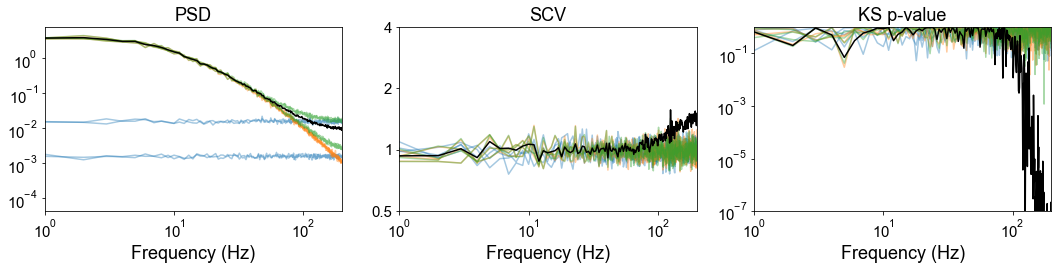

In [30]:
CKEYS = plt.rcParams['axes.prop_cycle'].by_key()['color']
plot_colors = [CKEYS[0], CKEYS[1], CKEYS[2], 'k']
plt.figure(figsize=(15,4))
for i,lf in enumerate(lfpca_all):
    lf.plot_spectral(plot_mean=False, plot_color=plot_colors[i])

### Observation: HFA increase manifested as poisson noise blends into synaptic noise
- Poisson rate was increased 10-fold on even trials (two levels of blue flat spectrum), which, added onto the constant synaptic noise (orange), produces two result spectra (green).
- Interestingly, green traces have noise-like SCV and KS-stats, hence adding white to colored noise does not disturb the noise-like properties at those blended frequencies, even at the intersection frequency (~100Hz for 10x firing), which was surprising for me. I expected that adding two exponential distributions will produce a non-exponential distribution, but I suppose power is computed not as draws from two exponential distributions, but prior to the "random draw".
- Combining the two conditions together into one long "recording", however, produces spectra that violate the noise properties (black), and only at the high frequencies, because of the rate change, which was expected.

# To Do:
### change in synaptic noise rate
### Simulating ERP-like events (or, SCP) in noise